<a href="https://colab.research.google.com/github/sandhyaparna/Python-DataScience-CookBook/blob/master/Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Tensorflow is the most used library in development of Deep Learning models. Keras, on the other end, is a high-level API that is built on top of TensorFlow. In order to train your own custom neural networks, Keras required a backend. A backend is a computational engine — it builds the network graph/topology, runs the optimizers, and performs the actual number crunching. TensorFlow is the default backend starting from the release of Keras v1.1.0. (earlier it was Theano)
* tf.keras - In Tensorflow 2, Keras is the official high-level API of TensorFlow for quick and easy model design and training.
  * Standalone Keras. The standalone open source project that supports TensorFlow, Theano and CNTK backends.
  * tf.keras. The Keras API integrated into TensorFlow 2.

In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.1


**The five steps in the life-cycle are as follows:** </br>
https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/
* Define the model: defining the layers of the model, configuring each layer with a number of nodes and activation function, and connecting the layers together into a cohesive model.
* Compile the model: select a loss function that you want to optimize, algorithm to perform the optimization procedure, and performance metrics to keep track of during the model training process.
* Fit the model: number of epochs (loops through the training dataset) and the batch size (number of samples in an epoch used to estimate model error).
* Evaluate the model: Evaluate model on hold-out dataset
* Make predictions: Predict on new data



Note: It is possible to bake this tf.nn.softmax in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

#### Sequential API 
* A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
* A Sequential model is not appropriate when:
  * Your model has multiple inputs or multiple outputs
  * Any of your layers has multiple inputs or multiple outputs
  * You need to do layer sharing
  * You want non-linear topology (e.g. a residual connection, a multi-branch model)

In [6]:
model = tf.keras.models.Sequential([
  # Input shape is required to be able to create weights. When you instantiate a Sequential model without an input shape, it isn't "built": it has no weights 
  tf.keras.layers.Flatten(input_shape=(250, 250, 3)), # input_shape=(4,), the first layer can receive an `input_shape` argument and recommended best practice is to always specify the input shape of a Sequential model in advance if you know what it is. 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)]) #the model returns a vector of "logits" or "log-odds" scores

# # Using add
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(2, activation="relu"))
# model.pop() # Removes lasyt layer

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x = tf.ones((1, 250, 250, 3))
y = model(x)
model.fit(x, y, epochs=100, batch_size=32, verbose=0)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 187500)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               24000128  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 24,001,418
Trainable params: 24,001,418
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Extracting the outputs of all intermediate layers in a Sequential model:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers],)
x = tf.ones((1, 250, 250, 3))
print("All layers:\n",feature_extractor(x)) # 2 layers

# example that only extract features from one layer:
initial_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(250, 250, 3)),
        tf.keras.layers.Conv2D(32, 5, strides=2, activation="relu"),
        tf.keras.layers.Conv2D(32, 3, activation="relu", name="my_intermediate_layer"),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
    ])
feature_extractor = tf.keras.Model(
    inputs=initial_model.inputs,
    outputs=initial_model.get_layer(name="my_intermediate_layer").output,)
x = tf.ones((1, 250, 250, 3))
print("One layer: \n",feature_extractor(x))
# 187500 is 250*250*3

#### Functional API 
* The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.



In [7]:
inputs = tf.keras.Input(shape=(784,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)

outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_name")
model.summary()

# Fully Connected layers: Param #: (current layer neurons c * previous layer neurons p)+(current layer neurons)

Model: "model_name"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [9]:
encoder_input = tf.keras.Input(shape=(28, 28, 1), name="img") # input_shape=(32,32,3) implies 32*32 color images. RGB = 3 channels
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(encoder_input) # 16 filters in the layers, filter size is 3*3 # output shape is 28-3+1=26 size and 16 filters. Param # is ((3*3*1)+1)*16
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x) # 32 filters in the layers, filter size is 3*3
x = tf.keras.layers.MaxPooling2D(3)(x) 
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = tf.keras.layers.GlobalMaxPooling2D()(x)

encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

#### Multilayer Perceptron Models
* A Multilayer Perceptron model, or MLP for short, is a standard fully connected neural network model. It is comprised of layers of nodes where each node is connected to all outputs from the previous layer and the output of each node is connected to all inputs for nodes in the next layer.
* An MLP is created by with one or more Dense layers. This model is appropriate for tabular data, that is data as it looks in a table or spreadsheet with one column for each variable and one row for each variable. There are three predictive modeling problems you may want to explore with an MLP; they are binary classification, multiclass classification, and regression



In [ ]:
# MLP for Binary Classification
# determine the number of input features
n_features = X_train.shape[1]

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [ ]:
# MLP for Multiclass Classification
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# MLP for Regression
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')

####  Convolutional Neural Network Models
* They are comprised of models with convolutional layers that extract features (called feature maps) and pooling layers that distill features down to the most salient elements.
* Stride denotes how many steps we are moving in each steps in convolution.
* Padding is a process of adding zeros to the input matrix symmetrically. Conv2D class can take one of two values: ‘valid’ or ‘same’.

* Input & Output shapes: https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca
  * Outputshape: (batch_size, 28, 28, 1): when batch_size=None there is no batch size value in the input_shape argument, we could go with any batch size while fitting the data.
  * You always have to feed a 4D array of shape (batch_size, height, width, depth) to the CNN.
  * Output data from CNN is also a 4D array of shape (batch_size, height, width, depth).
  * To add a Dense layer on top of the CNN layer, we have to change the 4D output of CNN to 2D using a Flatten layer.



* Number of parameters in CNN: https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
  * ((m * n * d)+1)* k), = ((shape of width of the filter * shape of height of the filter * number of filters in the previous layer+1)*number of filters)
  * Pool layer has got no learnable parameters because all it does is calculate a specific number, no backprop learning involved! Thus number of parameters = 0


In [ ]:
# determine the shape of the input images
in_shape = x_train.shape[1:]
# determine the number of classes
n_classes = len(unique(y_train))
print(in_shape, n_classes)

# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# define model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)

# evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=0)

#### Recurrent Neural Network Models
* They have proven to be very effective for natural language processing problems where sequences of text are provided as input to the model. RNNs have also seen some modest success for time series forecasting and speech recognition.
* LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in this case it is 5), and the second is the number of observations per time step (in this case it is 1).

* Input and Output shapes in LSTM: https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
  * The input of the LSTM is always is a 3D array. (batch_size, time_steps, units)
  * The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
  * If return_sequence is False, the output is a 2D array. (batch_size, units)
  * If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)


In [ ]:
Input 				Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8
...
# specify the window size
n_steps = 5

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))


#### Visualize a Deep Learning Model

In [ ]:
# example of summarizing a model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(8,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

# summarize the model
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


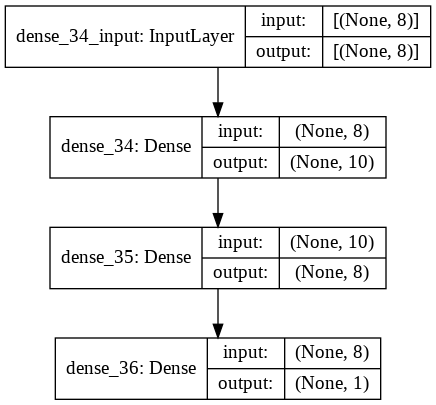

In [ ]:
# example of plotting a model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(8,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

# summarize the model
plot_model(model, 'model.png', show_shapes=True)

#### **Plot Model Learning Curves**
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
* Learning curves are a plot of neural network model performance over time, such as calculated at the end of each training epoch.
* Learning Curve: Line plot of learning (y-axis) over experience (x-axis).
  * Train Learning Curve: Learning curve calculated from the training dataset that gives an idea of how well the model is learning.
  * Validation Learning Curve: Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.
* create learning curves for multiple metrics, such as in the case of classification predictive modeling problems, where the model may be optimized according to cross-entropy loss and model performance is evaluated using classification accuracy. 
  * Optimization Learning Curves: Learning curves calculated on the metric by which the parameters of the model are being optimized, e.g. loss.
  * Performance Learning Curves: Learning curves calculated on the metric by which the model will be evaluated and selected, e.g. accuracy.

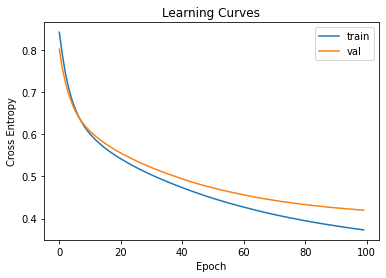

In [ ]:
# example of plotting learning curves
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# create the dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# compile the model
sgd = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy')

# fit the model
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.3)
# history.history has loss and val_loss only

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

#### **Save and Load Your Model**
* This can be achieved using the save() function on the model to save the model. It can be loaded later using the load_model() function.
* The model is saved in H5 format, an efficient array storage format. As such, you must ensure that the h5py library is installed on your workstation. 





In [ ]:
# example of saving a fit model
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# create the dataset
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=1)

# determine the number of input features
n_features = X.shape[1]

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# compile the model
sgd = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy')

# fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.3)

# save model to file
model.save('model.h5')

In [ ]:
# load the model from file
model = load_model('model.h5')
# make a prediction
row = [1.91518414, 1.14995454, -1.52847073, 0.79430654]
yhat = model.predict([row])
print('Predicted: %.3f' % yhat[0])

Predicted: 0.858


#### **Get Better Model Performance**


* DropOut https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
  * Dropout regularization is a generic approach.
  * Like other regularization methods, dropout is more effective on those problems where there is a limited amount of training data and the model is likely to overfit the training data. Problems where there is a large amount of training data may see less benefit from using dropout.
  * It can be used with most, perhaps all, types of neural network models, not least the most common network types of Multilayer Perceptrons, Convolutional Neural Networks, and Long Short-Term Memory Recurrent Neural Networks.
  * In the case of LSTMs, it may be desirable to use different dropout rates for the input and recurrent connections.
  * Dropout Rate: 1.0 means no dropout, and 0.0 means no outputs from the layer. A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, such as of 0.8. test values between 1.0 and 0.1 in increments of 0.1
  * A good rule of thumb is to divide the number of nodes in the layer before dropout by the proposed dropout rate and use that as the number of nodes in the new network that uses dropout. For example, a network with 100 nodes and a proposed dropout rate of 0.5 will require 200 nodes (100 / 0.5) when using dropout.
  * Network weights will increase in size in response to the probabilistic removal (drop-out) of layer activations. Large weight size can be a sign of an unstable network. To counter this effect a weight constraint can be imposed to force the norm (magnitude) of all weights in a layer to be below a specified value. For example, the maximum norm constraint is recommended with a value between 3-4.

In [ ]:
# Drop-out layer
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

* Accelerate Training With Batch Normalization https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ </br>
https://www.tensorflow.org/addons/tutorials/layers_normalizations
  * Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.
  * Batch normalization may be used on the inputs to the layer before or after the activation function in the previous layer. It may be more appropriate after the activation function if for s-shaped functions like the hyperbolic tangent and logistic function. It may be appropriate before the activation function for activations that may result in non-Gaussian distributions like the rectified linear activation function, the modern default for most network types.
  * Use Large Learning Rates - Using batch normalization makes the network more stable during training. This may require the use of much larger than normal learning rates, that in turn may further speed up the learning process.
  * Less Sensitive to Weight Initialization - The stability to training brought by batch normalization can make training deep networks less sensitive to the choice of weight initialization method.
  * If the mean and standard deviations calculated for each input feature are calculated over the mini-batch instead of over the entire training dataset, then the batch size must be sufficiently representative of the range of each variable.
  * Batch normalization offers some regularization effect, reducing generalization error, perhaps no longer requiring the use of dropout for regularization.

In [ ]:
# Batch Normalization layer is added prior to the layer you wish to have standardized inputs
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

* Halt Training at the Right Time With Early Stopping https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/
  * Involves monitoring the loss on the training dataset and a validation dataset (a subset of the training set not used to fit the model). As soon as loss for the validation set starts to show signs of overfitting, the training process can be stopped.
  * It is common to split the training dataset and use a subset, such as 30%, as a validation dataset used to monitor performance of the model during training. This validation set is not used to train the model. It is also common to use the loss on a validation dataset as the metric to monitor, although you may also use prediction error in the case of regression, or accuracy in the case of classification.
  * Performance of the model is evaluated on the validation set at the end of each epoch, which adds an additional computational cost during training. This can be reduced by evaluating the model less frequently, such as every 2, 5, or 10 training epochs.
  * Some more elaborate triggers may include:
    * No change in metric over a given number of epochs.
    * An absolute change in a metric.
    * A decrease in performance observed over a given number of epochs.
    * Average change in metric over a given number of epochs.
  * Plot Learning Curves to Select a Trigger - Before using early stopping, it may be interesting to fit an under constrained model and monitor the performance of the model on a train and validation dataset.
  * Repeating the early stopping procedure many times may result in the model overfitting the validation dataset.

In [ ]:
# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=5)
# fit the model
history = model.fit(X, y, epochs=200, batch_size=32, verbose=0, validation_split=0.3, callbacks=[es])

### **Loss Functions**

Difference between loss and metrics
* The loss function is that parameter one passes to Keras model.compile which is actually optimized while training the model . 
* metric is used for judging the performance of the model.

In [ ]:
### loss functions for Regression

# Last layer of the model should be
model.add(Dense(1, activation='linear'))

# Mean Squared Error Loss - if the distribution of the target variable is Gaussian/Normal
model.compile(loss='mean_squared_error', metrics=['mse']) 

# Mean Squared Logarithmic Error Loss - When target value has a spread of values and when predicting a large value, you may not want to punish a model as heavily as mean squared error.
# first calculates the natural logarithm of each of the predicted values, then calculate the mean squared error
model.compile(loss='mean_squared_logarithmic_error')

# Mean Absolute Error Loss - When distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value. it is more robust to outliers
# It is calculated as the average of the absolute difference between the actual and predicted values
model.compile(loss='mean_absolute_error')

# The poisson loss function is used for regression when modeling count data. Use for data follows the poisson distribution. Ex: churn of customers next week. 
# Use the Poisson loss when you believe that the target value comes from a Poisson distribution and want to model the rate parameter conditioned on some input. 
# Examples of this are the number of customers that will enter a store on a given day, the number of emails that will arrive within the next hour, or how many customers that will churn next week.
# Computes the Poisson loss between y_true and y_pred.
# loss = y_pred - y_true * log(y_pred)
model.compile(loss='mean_absolute_error')

In [ ]:
### loss functions for Classification

# Binary Cross-Entropy Loss - It is intended for use with binary classification where the target values are in the set {0, 1}
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
# Last layer of the model should be
model.add(Dense(1, activation='sigmoid'))

# Hinge Loss - It is intended for use with binary classification where the target values are in the set {-1, 1}. primarily developed for use with Support Vector Machine (SVM) models.
# The hinge loss function encourages examples to have the correct sign, assigning more error when there is a difference in the sign between the actual and predicted class values.
model.compile(loss='hinge')
# Last layer of the model should be
model.add(Dense(1, activation='tanh')) # Activation function is tanh as range is [-1,1]


# Squared Hinge Loss - It is intended for use with binary classification where the target values are in the set {-1, 1}. 
# If using a hinge loss does result in better performance on a given binary classification problem, is likely that a squared hinge loss may be appropriate.
# It has the effect of smoothing the surface of the error function and making it numerically easier to work with.
model.compile(loss='squared_hinge')
# Last layer of the model should be
model.add(Dense(1, activation='tanh')) # Activation function is tanh as range is [-1,1]


In [ ]:
### Multi-Class Classification Loss Functions

# Last layer of the model should be
model.add(Dense(n, activation='softmax')) # n (number of nodes) is number of classes. this means that the target variable must be one hot encoded before splitting into train and test and before fitting the model

# Cross-entropy is the default loss function to use for multi-class classification problems where each class is assigned a unique integer value
model.compile(loss='categorical_crossentropy')

# Sparse Multiclass Cross-Entropy Loss: Sparse cross-entropy addresses this by performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training.
# For example, predicting words in a vocabulary may have tens or hundreds of thousands of categories, one for each label. This can mean that the target element of each training example may require a one hot encoded vector with tens or hundreds of thousands of zero values, requiring significant memory.
model.compile(loss='sparse_categorical_crossentropy')

# Kullback Leibler Divergence Loss
# Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution
# KL divergence loss function is more commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred.

model.compile(loss='kullback_leibler_divergence')

